https://www.medrxiv.org/content/10.1101/2020.05.01.20088047v1.full.pdf


In [23]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit, lsq_linear
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm import tqdm
import ipywidgets as widgets
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%autoreload
import codebase
from codebase.sparse_regression import *
from codebase.utils import *

ds = CountryDataset()

In [27]:
def fit_parameters(sir,
                   window = 10,
                   step = 1): 
    
    def augment_sir_and_mk_targets(s, i, r, total_pop):
        s_t, i_t, r_t = s[1:], i[1:], r[1:]
        s_f, i_f, r_f = s[:-1], i[:-1], r[:-1]
        isn = s_f*i_f/total_pop
        augmented = np.block([[s_f, i_f, r_f],
                              [-isn, isn, np.zeros_like(s_f)],
                              [np.zeros_like(s_f),-i_f , i_f]])
        targets = np.concatenate([s_t, i_t, r_t]).reshape(-1, 1)
        return augmented.T, targets

    params = []

    for k in range(((len(sir) - window)//step) + 1):
        beginning = k*step
        end = beginning + window
        current_susceptible = sir[beginning:end, 0]
        current_infected = sir[beginning:end, 1]
        current_recovered = sir[beginning:end, 2]
        augmented, targets = augment_sir_and_mk_targets(current_susceptible, current_infected, current_recovered, sir[0, 0])
        [one, beta, gamma] = lsq_linear(augmented, targets.reshape(-1), bounds=([0.5, -np.inf, 0.06], [1.5, np.inf, 0.07]))['x']
        params.append([beta, gamma, (current_infected + current_recovered).mean()])

    return np.array(params)

def visualize(country):
    rescaling = 1

    fit_rescaling = 1000

    params = fit_parameters(dataset.sir(country), window=5)
    plot_params = params[(params[:, 2] > 0) & (params[:, 2] < np.inf) & (params[:, 1]*params[:, 0] > 0)]
    plot_params[:, 2] /= fit_rescaling
    
    stringency = dataset.stringency(country)

    f, ax1 = plt.subplots()
    ax1.plot(np.pad(plot_params.T[0]/ plot_params.T[1], (len(stringency)-len(plot_params), 0), 'edge'), label='R0')
    # ax1.plot(plot_params.T[0], label='beta')
    # ax1.plot(plot_params.T[1], label='gamma')
    plt.yscale('log')
    ax2 = ax1.twinx()
    ax2.plot(stringency, 'r')
    # plt.legend()
    plt.plot()
    
# widgets.interact(visualize, country=dataset.all_hopkins_countries());


## Generated data

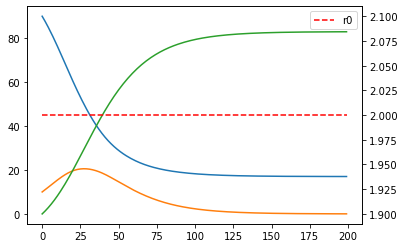

In [48]:
total_population = 1e2
t = np.arange(200)
initial_value = np.array([total_population*0.9, total_population*0.1, 0])

def r0(t):
    # return min(3., 20*np.exp(-t*0.2)) # + np.random.randn()*0.5
#     if t < 3:
#         return 2.5
#     elif t < 15:
#         return 1.
#     elif t < 20:
#         return 0.8
#     elif t < 40:
#         return 1.1
#     else:
#         return 2.
    return 2

def func(t, x, beta=1.5, gamma=0.065, total_pop=total_population):
    [s, i, r] = x
    isn = gamma*r0(t)*s*i/total_pop
    return np.array([-isn, isn - gamma*i, gamma*i])
                    


res = solve_ivp(func, (t[0], t[-1]), initial_value, t_eval=t)

f, ax = plt.subplots()
ax.plot(res.y.T)

ax1 = ax.twinx()

ax1.plot(np.vectorize(r0)(t), 'r--', label='r0')
ax1.legend()

In [59]:
result = []

for a, b, c in [(0.99, 0.01, 0),
                (0.9, 0.1, 0),
                (0.9, 0.05, 0.05),
                (0.8, 0.1, 0.1),
                (0.7, 0.2, 0.1)]:
    res = solve_ivp(func, (t[0], t[-1]), [total_population*a, total_population*b, total_population*c], t_eval=t)
    result.append(res.y.T)

    

result = np.array(result)
result.shape

(5, 200, 3)

In [63]:
targets, X = make_targets(result, derivative=(derivative:=True))

augmented, _ = make_polynomials(X, max_degree=2)

learning_limit = 100

weights, _ = sparse_regression(augmented[:learning_limit], targets[:learning_limit], cutoff=3e-4)

show_weights(weights, variables=['1', 's', 'i', 'r'], derivative=derivative)

| function   |   $\dot{s}$ |    $\dot{i}$ |   $\dot{r}$ |
|:-----------|------------:|-------------:|------------:|
| $1$        |  0          |  0           | 0           |
| $ s$       |  0          |  0           | 0           |
| $ i$       |  0          |  0           | 0           |
| $ r$       |  0          |  0           | 0           |
| $ s^2$     |  0          |  0           | 0           |
| $ s i$     | -0.00129935 |  0.000812943 | 0           |
| $ s r$     |  0          | -0.000340214 | 0.000540295 |
| $ i^2$     |  0          |  0           | 0           |
| $ i r$     |  0          |  0           | 0           |
| $ r^2$     |  0          |  0           | 0           |

[]

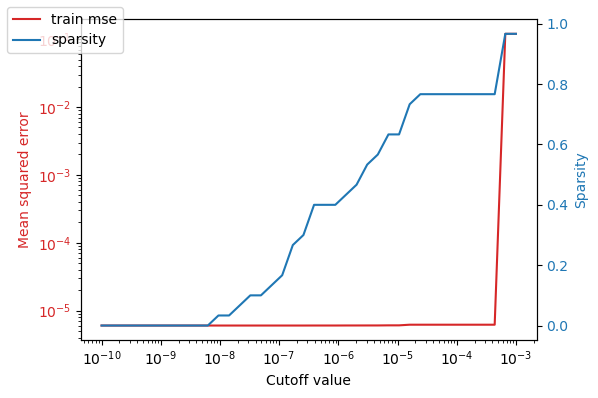

In [62]:
%autoreload

rest = cutoff_mses(augmented, targets, -10, -3)

fig, ax1 = plt.subplots(dpi=100)

color = 'tab:red'
ax1.set_xlabel('Cutoff value')
ax1.set_ylabel('Mean squared error', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(rest['cutoffs'], rest['mses'], color=color, label='train mse')
ax1.tick_params(axis='y')

handles, labels = ax1.get_legend_handles_labels()

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Sparsity', color=color)
ax2.plot(rest['cutoffs'], rest['sparsity'], color=color, label='sparsity')
ax2.set_xscale('log')
ax2.tick_params(axis='y', labelcolor=color)
handles2, labels2 = ax2.get_legend_handles_labels()
handles += handles2
labels += labels2

fig.legend(handles, labels, loc='upper left')

fig.tight_layout()
plt.plot()

In [20]:
learning_limit = 200

weights, _ = sparse_regression(augmented[:learning_limit], targets[:learning_limit], cutoff=2e-11)

show_weights(weights, variables=['1', 's', 'i', 'r'], derivative=derivative)

| function   |    $\dot{s}$ |    $\dot{i}$ |    $\dot{r}$ |
|:-----------|-------------:|-------------:|-------------:|
| $1$        | -1.92454e-07 | -3.64146e-08 |  2.28869e-07 |
| $ s$       | -1.24e-05    |  6.38134e-06 |  6.01863e-06 |
| $ i$       | -8.1418e-06  | -5.18579e-06 |  1.33277e-05 |
| $ r$       | -6.28525e-07 | -5.20136e-06 |  5.82988e-06 |
| $ s^2$     | -2.12918e-05 |  9.85055e-06 |  1.14409e-05 |
| $ s i$     | -0.00109979  |  0.00061349  |  0.000486299 |
| $ s r$     | -0.000242917 |  7.86099e-05 |  0.000164303 |
| $ i^2$     |  6.86142e-05 | -0.000545519 |  0.000476907 |
| $ i r$     |  0.000135575 | -0.000638407 |  0.000502835 |
| $ r^2$     |  3.82546e-05 | -1.23292e-05 | -2.59248e-05 |

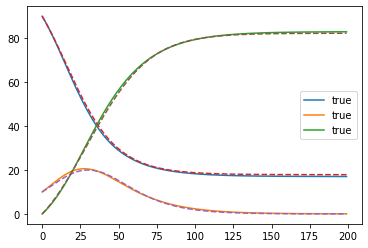

In [51]:
initial_state = initial_value # [total_population*0.6, total_population*0.3, total_population*0.1]
guess = integrate(weights, initial_state, t, derivative=derivative)

plt.plot(res.y.T, label='true')
plt.plot(guess, '--')
plt.legend()
plt.show()

[]

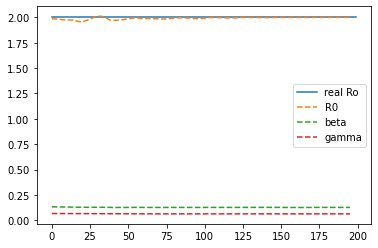

In [32]:
fit_rescaling = 1

params = fit_parameters(res.y.T, window=5)
plot_params = params
plot_params[:, 2] /= fit_rescaling

plt.plot(np.vectorize(r0)(t), label='real Ro')
plt.plot(plot_params.T[0]/ plot_params.T[1], '--', label='R0')
plt.plot(plot_params.T[0], '--', label='beta')
plt.plot(plot_params.T[1], '--', label='gamma')
plt.legend()
# plt.yscale('log')
plt.plot()

In [ ]:
X, dm = augmented, targets

cutoffs = np.logspace(-13, -2, num=80)
sparsity = []
mses = []
all_weights = []

for k in tqdm(cutoffs, ncols=50):
    weights, _ = sparse_regression(X, dm, cutoff=k)
    all_weights.append(weights)
    mse = ((tf.matmul(tf.cast(X, dtype=tf.float32), tf.cast(weights, dtype=tf.float32)) - dm)**2).numpy().mean()
    mses.append(mse)
    sparsity.append((weights.numpy() == 0).sum()/len(weights.numpy().flatten()))

fig, ax1 = plt.subplots(dpi=100)

color = 'tab:red'
ax1.set_xlabel('Cutoff value')
ax1.set_ylabel('Mean squared error', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(cutoffs, mses, color=color, label='mse')
ax1.tick_params(axis='y')

handles, labels = ax1.get_legend_handles_labels()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Sparsity', color=color)  # we already handled the x-label with ax1
# ax2.plot(cutoffs, smapes, color='tab:purple', label='test smape')
ax2.plot(cutoffs, sparsity, color=color, label='sparsity')
ax2.set_xscale('log')
ax2.tick_params(axis='y', labelcolor=color)
handles2, labels2 = ax2.get_legend_handles_labels()
handles += handles2
labels += labels2

fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.13, 0., 0., 0.9))

plt.title('Optimal cutoff value')
fig.tight_layout()
plt.plot()

In [ ]:
show_weights(all_weights[68], variables=['1', 's', 'i', 'r'])